In [88]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torchvision.io import read_image
from tqdm.notebook import tqdm
from torchvision import transforms
from PIL import Image

import os

folder_path = './dataset/metadata.csv'
df = pd.read_csv(folder_path)
X = []
y = []
thumbnails_dir = './dataset/thumbnails-jpegs'
titles = []
img_transform = transforms.Compose([transforms.Resize((256,256))])
failed_indices = []
video_ids = []
for img in tqdm(os.listdir(thumbnails_dir), total=len(os.listdir(thumbnails_dir))):
    img_path = os.path.join(thumbnails_dir, img)
    loc = df.loc[df['Id'] == img[:-4]] ## locates the matching ids for images and corresponding feature in csv
    if loc.empty:                      ## as some of our data has no matching ids, just skip and remove the data
        os.remove(img_path)
    else:
        y.append(np.float32(np.asarray(loc['View Count'])[0]))  ## append target variable y for view count
        img = Image.open(img_path)
        thumb_256 = img_transform(img)       ## resize all images to 256 x 256, easier to work with in Conv2d
        # print(thumb_256)
        X.append(np.asarray(thumb_256))             ## append all images as arrays to X
        titles.append(loc.iloc[0]['Title'])
        video_ids.append(loc.iloc[0]['Id'])


# remove failed indices from the dataframe
df = df.drop(index=failed_indices)
df = df[df['Id'].isin(video_ids)]
assert(len(y) == len(X))       


  0%|          | 0/2297 [00:00<?, ?it/s]

In [89]:
print(len(video_ids))
print(video_ids)
len(df)

2297
['pKcJ-0bAHB4', 'GXDvZVYon8M', '2OSrvzNW9FE', 'G4xBNFD1p14', 'LTikuFFr7JA', 'TwIvUbOhcKE', 'aIYBZIM10DA', 'nxnZe6wjjqU', 'WLSNPkf8RCU', 'AhxpnCW1mp8', '8ehoj-y3b1s', '1UFPWzVucSc', '1TieKn0W4o0', 'UBPg5ftCMv8', 'SGNwG_MjslI', 'yQl-RYrbRas', 'AfaIM7Ybwj4', 'TtzAcNZYflc', '6CnuNPwx4pI', 'l0IefQRFVfE', 'h-StyszRCzc', 'MqarV06DDWo', 'ziUMJB3id8I', 'KHSdObeUdxI', 'uuhkVTJ6A_c', 'pYy5-KowMj0', 'lpcpsCY4Mco', 'fvu5FxKuqdQ', 'w9nM5WRD-qw', 'btaEDH775ko', 'scIizw2asro', 'oKbEuUjbGL0', 'AWkvzycD5PE', '-LKVUarhtvE', 'J5HtSy5bATk', 'jHbyQ_AQP8c', 'cJONS7sqi0o', 'saANxD0cqy0', 'd7qqu9HC7V0', 'O5BJVO3PDeQ', 'dCGS067s0zo', 'QEqVInxyL5w', 'fCn8zs912OE', 'ntfProwNYkE', 'goxvS5pxLDo', 'CEHMfdqwWXA', '7pOXunRYJIw', 'W9ME-WBlkeM', '7Q17ubqLfaM', '2fAv4kWLp8w', 'ZjS6rLKnU0c', 'jFNHkjsPqE0', 'ZDxLa6P6exc', '9WSBQne_8FE', 'HoyMs7XXSbw', 'Baa_Db8RfxM', '3TflpIllQHY', '6L8yUY-doNc', '8NLE8d4GW-Y', 'fuFQzAKbrtM', 'gqibxjObZ-I', 'YO4Pm-a7oZ4', 'hNWz9o6CSyM', 'CLUWDLKAF1M', 'tF0dCNxfYHk', '_RKYQdUUttc', 'rA1

2297

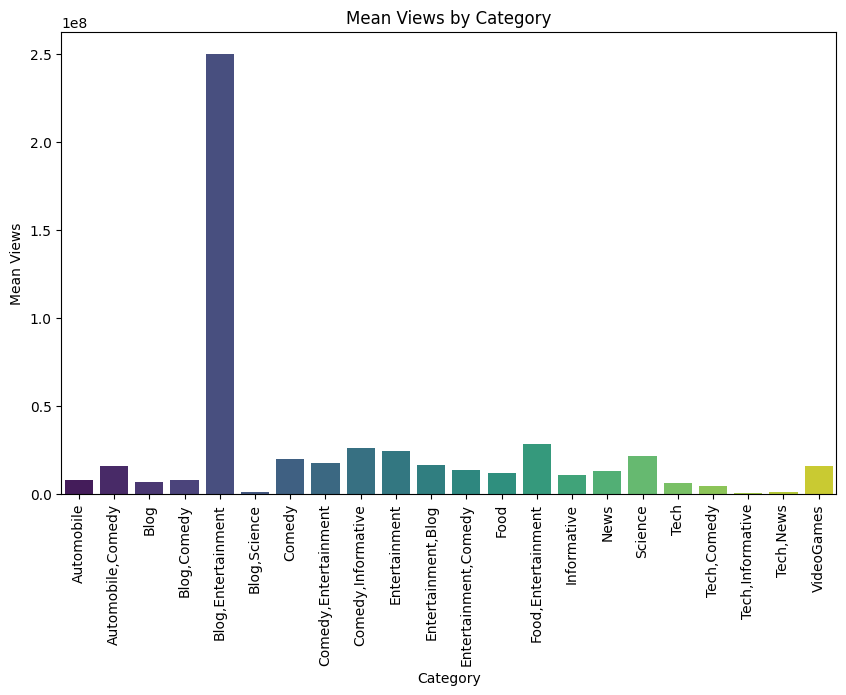

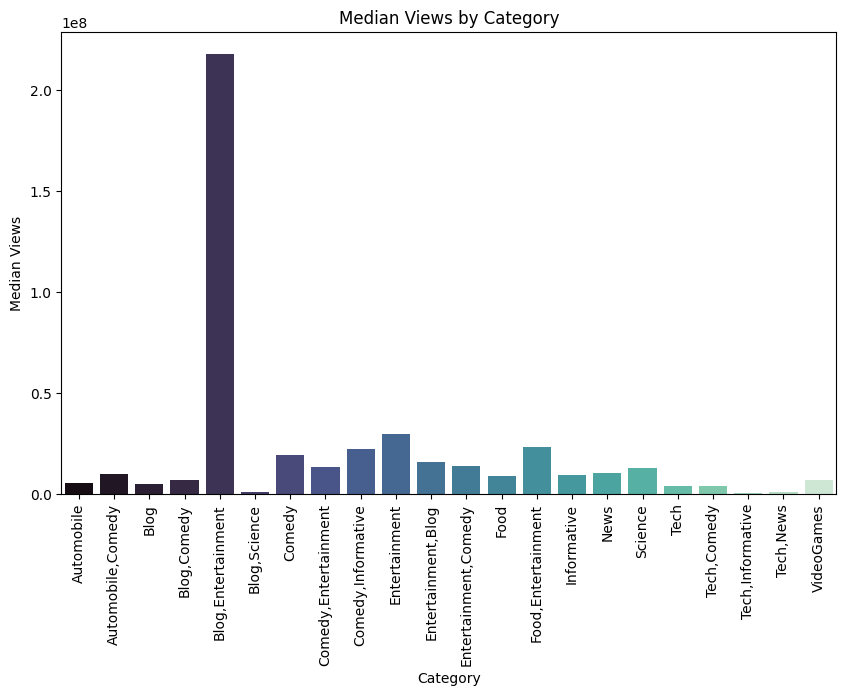

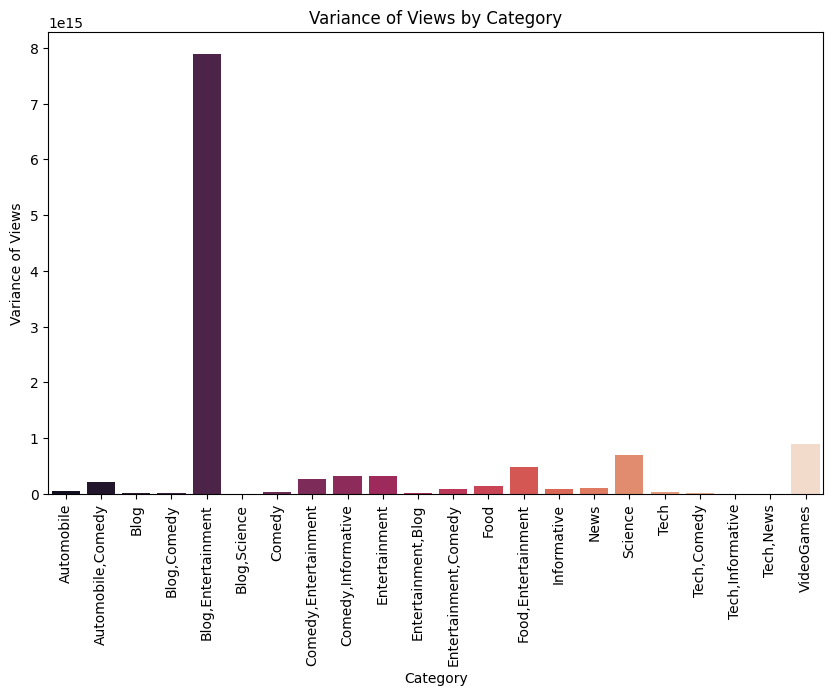

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns


grouped_stats = df.groupby('Category')['View Count'].agg(['mean', 'median', 'var']).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='mean', data=grouped_stats, palette='viridis')
plt.title('Mean Views by Category')
plt.xlabel('Category')
plt.ylabel('Mean Views')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='median', data=grouped_stats, palette='mako')
plt.title('Median Views by Category')
plt.xlabel('Category')
plt.ylabel('Median Views')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='var', data=grouped_stats, palette='rocket')
plt.title('Variance of Views by Category')
plt.xlabel('Category')
plt.ylabel('Variance of Views')
plt.xticks(rotation=90)
plt.show()

2297


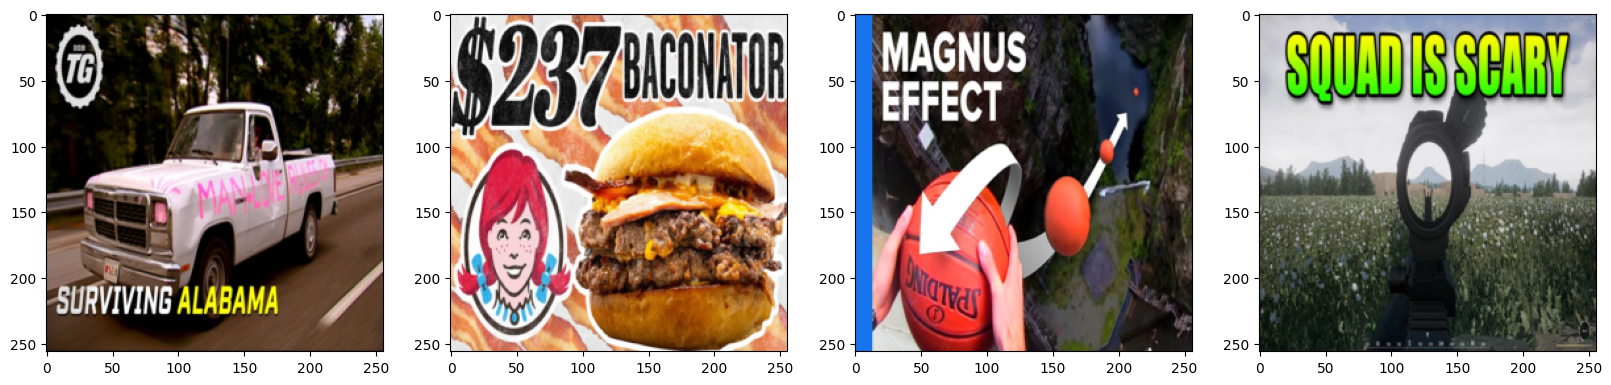

In [91]:
from matplotlib import pyplot as plt
print(len(X))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#print 5 thumbnails to verify tf.data works
for i in range(4):
    img = Image.fromarray(X[i].astype(np.uint8))
    ax[i].imshow(img)

In [125]:


# One-hot encoding
import clip
img_list = [img[:-4] for img in os.listdir(thumbnails_dir)]
categories_one_hot = pd.get_dummies(df['Category'][df['Id'].isin(img_list)])
# get separate categories_one_hot for ids actually in the dataset
categories_one_hot_array = categories_one_hot.values
_, preprocess = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, y, categories_one_hot_array):
        self.df : pd.DataFrame = df
        self.view_count = torch.Tensor(y)
        self.categories_one_hot_array = torch.Tensor(categories_one_hot_array)

    def __len__(self):
        return len(self.view_count)

    def __getitem__(self, idx):
        # return id from dataframe
        return preprocess(Image.open(os.path.join(thumbnails_dir, self.df.iloc[idx]['Id'] + '.jpg'))), self.df.iloc[idx]['Title'], self.categories_one_hot_array[idx], self.view_count[idx], 

def collate_fn(batch):
    image_paths = []
    titles = []
    categories = []
    view_counts = []
    for b in batch:
        image_paths.append(b[0])
        titles.append(b[1])
        categories.append(b[2])
        view_counts.append(b[3])
    images = torch.stack(image_paths)
    titles = clip.tokenize(titles)
    view_counts = torch.Tensor(view_counts) 
    categories = torch.stack(categories)
    return {'images': images, 'texts': titles, 'category': categories, 'labels': view_counts}

dataset = ImageDataset(df, y, categories_one_hot_array)
print(len(dataset))
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (0.7, 0.1, 0.2))

2297


In [132]:
import clip


class YoutubePredictor(nn.Module):
    
    def __init__(self):
        super(YoutubePredictor, self).__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-L/14", device=self.device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=1558, nhead=2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.linear = nn.Linear(1558, 1)
        self.loss = nn.MSELoss()
        
        
        
    def forward(self, images, texts, category, labels):
        with torch.no_grad():
            image_features = self.model.encode_image(images)
            text_features = self.model.encode_text(texts)
            vid_features = torch.cat((image_features, text_features, category), dim=1)   
        output = self.transformer_encoder(vid_features)
        output = self.linear(output)
        loss = self.loss(output.squeeze(), labels)
        return loss, output.squeeze()

    @torch.no_grad()
    def generate(self, images, texts, previous_video_feats):
        output = self.forward(images, texts, previous_video_feats)
        return output

In [133]:
from transformers import Trainer, TrainingArguments

os.environ["WANDB_DISABLED"]="true"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YoutubePredictor()
model.to(device)

train_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

from sklearn.metrics import mean_squared_error

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

trainer = Trainer(
    args=train_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/255 [00:00<?, ?it/s]

{'loss': 829056033908326.4, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.2}
{'loss': 768809346531328.0, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.39}
